In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn import preprocessing as pp

In [52]:
#preprocessing data for PCA
df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")
dfy = df2[" ATT_FLAG"]
dfy = dfy.replace(-999,0)
df2 = df2.drop(" ATT_FLAG",axis=1)
df2 = df2.drop("DATETIME",axis=1)
featuresToScale = df2.columns
sX = StandardScaler(copy=True)
df2.loc[:,featuresToScale] = sX.fit_transform(df2[featuresToScale])


In [53]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [54]:
#run pca on desired amount of components
n_components = 4
testdata = df2
def pcatest(n_components):
    pca = PCA(n_components=n_components)

    X_train_PCA = pca.fit_transform(testdata)
    X_train_PCA = pd.DataFrame(data=X_train_PCA, index=testdata.index)

    X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
    X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=testdata.index)
    return X_train_PCA_inverse,X_train_PCA
X_train_PCA_inverse, X_train_PCA = pcatest(n_components)



In [55]:
#calculate reconstruction error
anomalyScoresPCA = anomalyScores(testdata, X_train_PCA_inverse)

In [56]:
preds = pd.concat([dfy, anomalyScoresPCA], axis=1)
preds.columns = ['trueLabel', 'anomalyScore']
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 100
predsTop = preds[:cutoff]

TP= predsTop.anomalyScore[predsTop.trueLabel==1].count()
FP= cutoff-TP
print("Precision: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/dfy.sum(),2))
print("True positive: ", TP)
print("False positive: ", FP)

Precision:  0.84
Recall:  0.38
True positive:  84
False positive:  16


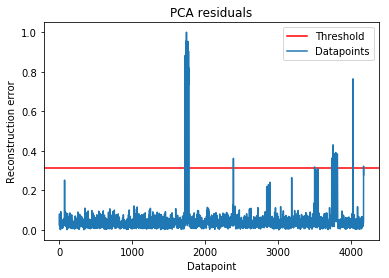

In [57]:
#daar zitten ze dus
threshold = predsTop.anomalyScore.iloc[-1]
fig = plt.figure()

ax = fig.add_subplot(111)
ax.axhline(y=threshold, label='Threshold',color="r")
ax.plot(anomalyScoresPCA,label = "Datapoints")
ax.set_title('PCA residuals')
ax.set_xlabel('Datapoint')
ax.set_ylabel('Reconstruction error')
ax.legend()
plt.show()